# Лабораторная работа №2 «Оптимизация потерь в задачах классификации»

## Примечание

В столбцах `prediction1`, `prediction2`, `prediction3` файла `data.csv` содержатся результаты предсказания соответствия классу 1 некоторых классификаторов (трех вариантов глубокой нейронной сети) для тестовой выборки. Столбец `label` содержит истинные классы объектов. 


### Полезные кусочки кода

#### Построение кривой ошибок расчет площади под ней:

```python
fpr, tpr, _ = sklearn.metrics.roc_curve(true_class, prediction)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()
print('Площадь под кривой =', sklearn.metrics.roc_auc_score(true_class, prediction) )
```

#### Продвинутый алгоритм вычисления вероятностей - метод парзеновского окна:

```python
from statsmodels.nonparametric.kernel_regression import KernelReg
kr = KernelReg(endog=y, exog=x, var_type='c', bw=[0.2])
prob, _ = kr.fit(x)
```

## Работа

### Подготовка

In [58]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.20f' % x)
import sklearn.metrics  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
import numpy as np  # noqa: E402
from statsmodels.nonparametric.kernel_regression import KernelReg  # noqa: E402

In [59]:
data = pd.read_csv("data.csv", delimiter=',')
data.describe()

,prediction1,prediction2,prediction3,label
count,10000.00000000000000000000,10000.00000000000000000000,10000.00000000000000000000,10000.00000000000000000000
mean,-0.00000000000000002913,-0.00000000000000002842,-0.00000000000000004547,0.52029999999999998472
std,0.57743687966940049350,0.57743687966940049350,0.57743687966940049350,0.49961272130233902455
min,-1.00000000000000000000,-1.00000000000000000000,-1.00000000000000000000,0.00000000000000000000
25%,-0.50000000000000011102,-0.50000000000000011102,-0.50000000000000011102,0.00000000000000000000
50%,-0.00000000000000010000,-0.00000000000000010000,-0.00000000000000010000,1.00000000000000000000
75%,0.49999999999999994449,0.49999999999999994449,0.49999999999999994449,1.00000000000000000000
max,1.00000000000000000000,1.00000000000000000000,1.00000000000000000000,1.00000000000000000000


In [60]:
data

,prediction1,prediction2,prediction3,label
0,1.00000000000000000000,1.00000000000000000000,-1.00000000000000000000,1.00000000000000000000
1,-0.01970197019701979899,0.03630363036303629887,0.18091809180918080879,1.00000000000000000000
2,-0.01950195019501950108,0.03650365036503640248,0.18131813181318121031,1.00000000000000000000
3,-0.01930193019301919971,0.03670367036703670038,0.18171817181718161183,1.00000000000000000000
4,-0.01910191019101899895,0.03690369036903679706,-0.77897789778977899466,1.00000000000000000000
...,...,...,...,...
9995,-0.14071407140714059514,-0.20612061206120618762,-0.14571457145714569736,0.00000000000000000000
9996,-0.14031403140314030464,-0.20552055205520539105,-0.14531453145314540687,0.00000000000000000000
9997,-0.14011401140114010389,-0.20472047204720458802,-0.14511451145114509509,0.00000000000000000000
9998,-0.13971397139713981339,-0.21092109210921100582,-0.14811481148114810646,0.00000000000000000000



### Задание 1
  
Постройте кривую ошибок для каждой нейросети. Чем они отличаются? Площадь под какой кривой больше? Трансформируйте предсказания нейросетей в вероятности класса 1 (далее будем обозначать их `probabilities`), предполагая, что тестовая выборка распределена точно так же, как и будут распределены объекты в будущем, к которым наш алгоритм планируется применять. Для этого можно действовать следующим образом. Для каждого значения, возвращаемого нейросетью, взять несколько похожих значений и вычислить среди них процент класса 1, т.е. по сути применить метод ближайших соседей к данным: `x` - предсказания нейросети, `y` - истинные классы. Постройте на одном графике зависимости вероятностей от величины предсказания для всех нейросетей.


In [61]:
def plot_roc_curve(prediction, true_class, axis, label):
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_class, prediction)
    axis.plot(fpr, tpr, color='darkorange', lw=2, label=label)
    axis.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    area = sklearn.metrics.roc_auc_score(true_class, prediction)
    axis.set_xlabel('False Positive Rate (FPR)')
    axis.set_title(f"A = {area}")
    axis.legend()
    # print('Площадь под кривой =', sklearn.metrics.roc_auc_score(true_class, prediction))

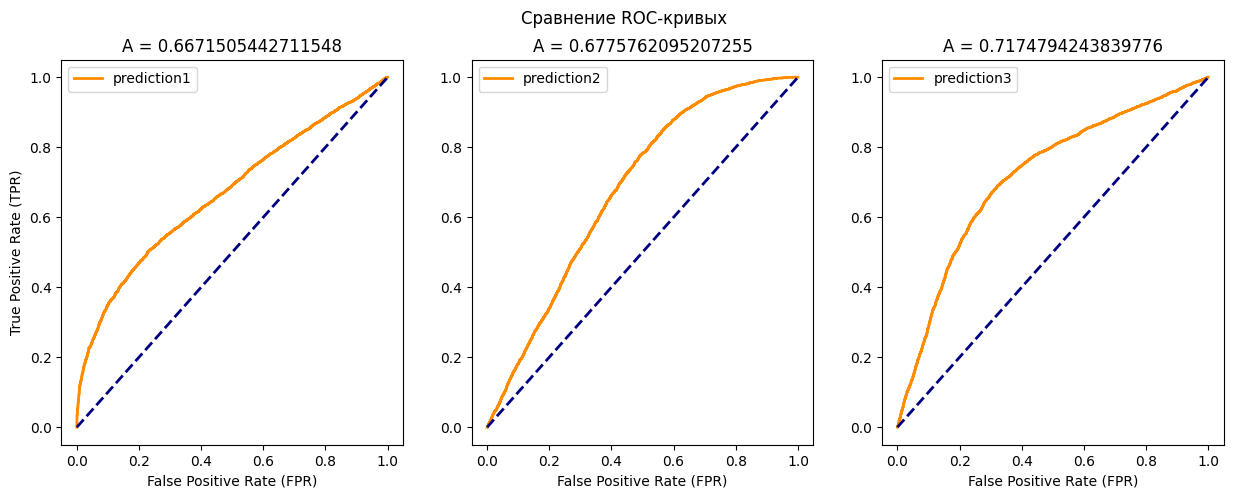

In [62]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

plot_roc_curve(data['prediction1'], data['label'], axes[0], 'prediction1')
axes[0].set_ylabel('True Positive Rate (TPR)')
plot_roc_curve(data['prediction2'], data['label'], axes[1], 'prediction2')
plot_roc_curve(data['prediction3'], data['label'], axes[2], 'prediction3')

plt.suptitle("Сравнение ROC-кривых")
# fig.text(0, 0.5, 'False Positive Rate', va='center', rotation='vertical')

plt.show()

In [63]:
def kernel_regression(x, y):
    kr = KernelReg(endog=y, exog=x, var_type='c', bw=[0.2])
    prob, _ = kr.fit(x)
    return prob

In [64]:
probabilities1 = kernel_regression(data['prediction1'], data['label'])
probabilities2 = kernel_regression(data['prediction2'], data['label'])
probabilities3 = kernel_regression(data['prediction3'], data['label'])

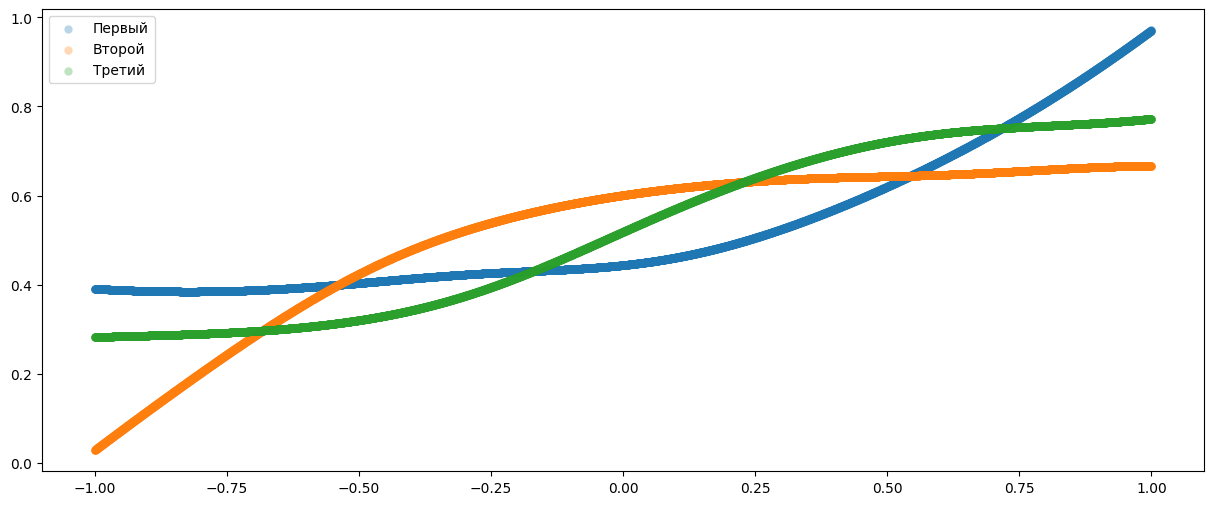

In [65]:
plt.figure(figsize=(15, 6))
plt.scatter(data['prediction1'], probabilities1, label='Первый', alpha=0.3, linewidth=0.001)
plt.scatter(data['prediction2'], probabilities2, label='Второй', alpha=0.3, linewidth=0.001)
plt.scatter(data['prediction3'], probabilities3, label='Третий', alpha=0.3, linewidth=0.001)
# plt.xlim(-1, -0.75)
# plt.ylim(0.38, 0.41)
plt.legend()
plt.show()

### Задание 2

Для каждой из нижеследующих задач на листике составьте таблицу потерь/прибыли в результате ошибочных/правильных ответов алгоритма (первая строка таблицы - вероятности исходов, остальные - потери/прибыль от каждого действия алгоритма, одна строка - одно действие). Для этого придумайте/найдите в интернете разумные величины штрафов и напишите их словесное обоснование (т.е. восполните недостающие данные в постановке задачи). 

Теоретически (на листике) найдите зависимость оптимального порогового значения от вероятности для каждой из нейросетей (это называется decision function). 

Запрограммируйте найденное пороговое значение и выясните, какие из нейросетей рентабельны и какие приносят наибольшую прибыль?

#### Задача №1

Задача выдачи кредита размером 1 млн. руб на 1 год. probabilities - вероятности возврата кредита клиентами (К). Ставка по кредиту: 4%. Ответьте на вопрос, следует ли в этой задаче учитывать "упущенную выгоду", есть ли в статистике обычного банка (Б) необходимые для этого данные?

##### Таблица

|  | К не вернул деньги | К вернул деньги |
| ---: | :---: | :---: |
| Вероятность | $1-p$ | $p$ |  |
| Б выдал кредит | $-1000000$ | $+40000$ | 
| Б не выдал кредит | 0 | 0 | 

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(data['label'], probabilities1)

optimal_threshold = thresholds[np.argmax(tpr - fpr)]

print(f'Оптимальный порог: {optimal_threshold:.2f}')

fpr, tpr, thresholds = roc_curve(data['label'], probabilities2)

optimal_threshold = thresholds[np.argmax(tpr - fpr)]

print(f'Оптимальный порог: {optimal_threshold:.2f}')

fpr, tpr, thresholds = roc_curve(data['label'], probabilities3)

optimal_threshold = thresholds[np.argmax(tpr - fpr)]

print(f'Оптимальный порог: {optimal_threshold:.2f}')



Оптимальный порог: 0.51
Оптимальный порог: 0.53
Оптимальный порог: 0.50


In [67]:
def plot_dependencies(lambdas, labels = []):
    P = [round(p, 2) for p in np.linspace(0, 1, num=10)]
    for f in lambdas:
        Y = [f(p) for p in P]
        plt.plot(P, Y)
        
    plt.legend(labels)
    plt.show()

def model_quality(true_class, probability, threshold, tpw, tnw, fpw, fnw):
    pred = probability > threshold
    FP = FN = TP = TN = 0
    for pred, actual in zip(pred, true_class):
        if pred == actual == 1:
            TP += 1
        elif pred == actual == 0:
            TN += 1
        elif pred != actual and pred == 1:
            FP += 1
        elif pred != actual and pred == 0:
            FN += 1
    return TP * tpw + TN * tnw + FP * fpw + FN * fnw

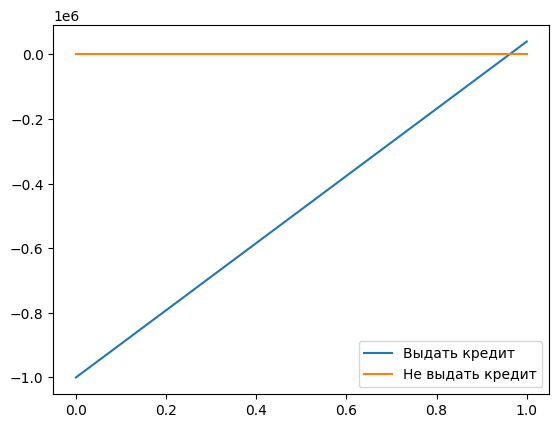

1120000
0
0


In [68]:
def give(p):
    return 40000 * p - 1000000 * (1 - p) 

def not_give(p):
    return 0

plot_dependencies([give, not_give], ["Выдать кредит", "Не выдать кредит"])

print(model_quality(data['label'], probabilities1, 25/26, 40_000, 0, -1_000_000, 0))
print(model_quality(data['label'], probabilities2, 25/26, 40_000, 0, -1_000_000, 0))
print(model_quality(data['label'], probabilities3, 25/26, 40_000, 0, -1_000_000, 0))

#### Задача №2

Задача предсказания существенного взлета/падения курса валюты в течении следующей недели более чем на 5%. Предполагается, что в выборку были добавлены только те промежутки времени, в течении которых произошло изменение курса более чем на 5%, причем 1 означает рост курса валюты, 0 - падение. Предположите для простоты, что операции покупки/продажи вы можете совершать каждую неделю, своих денег у вас нет, для каждой операции вам нужно занимать деньги у друга и в конце недели возвращать ему занятую сумму (без процентов).

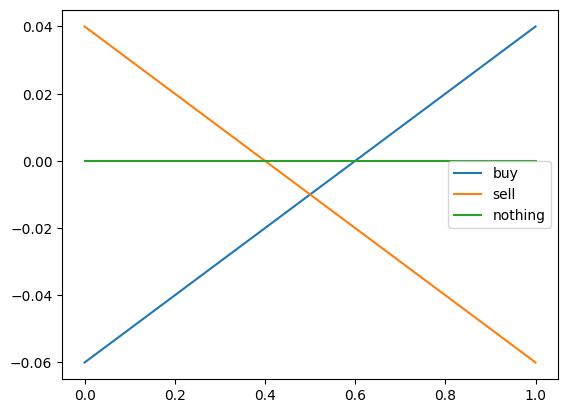

4638.000000000003 6196.000000000002 9090.000000000005


In [69]:
def profitForTask2(pred, actual, t1, t2, tpv, tnv, fpv, fnv):
    threePred = [0] * len(pred)
    
    for i in range(len(pred)):
        if pred[i] < t1:
            continue
        elif pred[i] > t2:
            threePred[i] = 1
        else:
            threePred[i] = 2
        
    FP = FN = TP = TN = 0
    for i, j in zip(threePred, actual):
        if i == j == 1:
            TP += 1
        if i == j == 0:
            TN += 1
        if i != j and i == 1:
            FP += 1
        if i != j and i == 0:
            FN += 1
    return (TP * tpv + TN * tnv + FP * fpv + FN * fnv) * 100

def buy(p):
    return 0.04 * p - 0.06 * (1 - p)

def sell(p):
    return -0.06 * p + 0.04 * (1 - p)

def nothing(x):
    return 0

plot_dependencies([buy, sell, nothing], ["buy", "sell", "nothing"])

print(profitForTask2(probabilities1, data['label'], 0.4, 0.6, 0.04, 0.04, -0.06, -0.06), \
      profitForTask2(probabilities2, data['label'], 0.4, 0.6, 0.04, 0.04, -0.06, -0.06), \
      profitForTask2(probabilities3, data['label'], 0.4, 0.6, 0.04, 0.04, -0.06, -0.06))

#### Задача №3

Задача предсказания определенного типа онкологии в частной клинике. probabilities - вероятность плохого диагноза. Алгоритм должен принять решение: а) лечить от онкологии опасными средствами, б) лечить от похожей болезни безопасными методами, в) отказаться от лечения. Лечение опасно (с вероятностью 60% пациент станет инвалидом III группы), но существенно продлевает жизнь. Сначала получите решение без учета репутационных потерь клиники, а потом с ними.

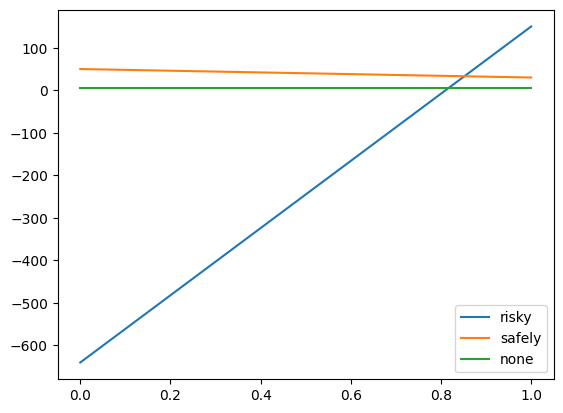

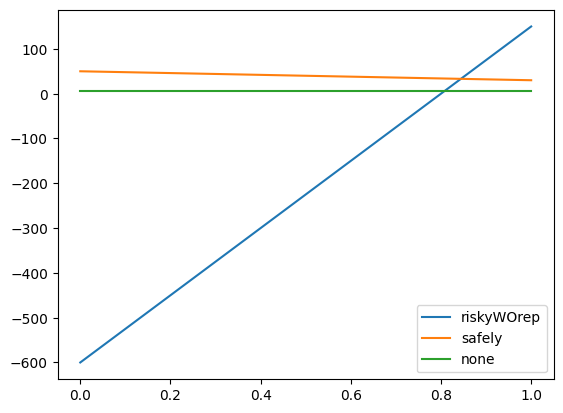

-3186010 -3186010 -3186010
-2977890 -2977890 -2977890


In [70]:
def risky(p):
    return 150 * p - 640 * (1 - p)

def riskyWOrep(p):
    return 150 * p - 600 * (1 - p)

def safely(p):
    return 30 * p + 50 * (1 - p)

def none(p):
    return 5 * p + 5 * (1 - p)

plot_dependencies([risky, safely, none], ["risky", "safely", "none"])
plot_dependencies([riskyWOrep, safely, none], ["riskyWOrep", "safely", "none"])

# with rep 
print(model_quality(probabilities1, data['label'], 23/27, 150, 50, -640, 30), \
      model_quality(probabilities2, data['label'], 23/27, 150, 50, -640, 30), \
      model_quality(probabilities3, data['label'], 23/27, 150, 50, -640, 30))

# without rep 
print(model_quality(probabilities1, data['label'], 65/77, 150, 50, -600, 30), \
      model_quality(probabilities2, data['label'], 65/77, 150, 50, -600, 30), \
      model_quality(probabilities3, data['label'], 65/77, 150, 50, -600, 30))

#### Задача №4

Задача определения оптимальной цены страховки в зависимости от вероятности (probabilities) клиента попасть в аварию с ценой ремонта более 20 тыс. руб в будущем году. Для каждого клиента ответьте на вопрос какая нейросеть лучше (экономически выгодней)? Для скольки процентов клиентов лучшей оказалась первая нейросеть (вторая, третья)?

In [71]:
def profitForTask4(pred):
    profit = 0
    for p in pred:
        profit += 20*p + 3
    return profit

print(profitForTask4(probabilities1), \
      profitForTask4(probabilities2), \
      profitForTask4(probabilities3))

# avg price for client
print(profitForTask4(probabilities1) / len(probabilities1), \
      profitForTask4(probabilities2) / len(probabilities2), \
      profitForTask4(probabilities3) / len(probabilities3))

135467.80044597038 132546.48739718928 134095.8678329323
13.546780044597037 13.254648739718927 13.40958678329323


#### Задача №5

Разработка медицинского теста коронавируса, который будет использоваться в качестве официального (т.е. в случае положительного результата человека отправляют на больничный (1 неделя), выдают бесплатно лекарства и бесплатно проводят дезинфекцию в квартире).

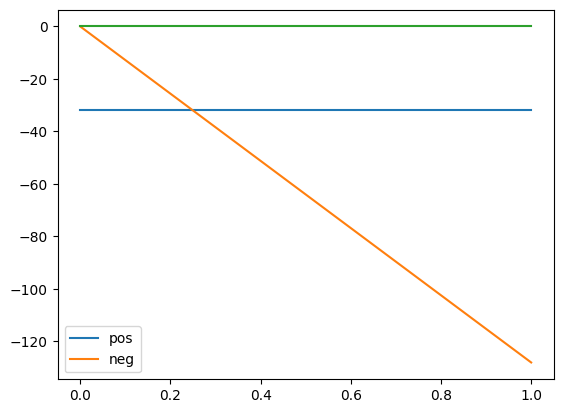

-780512 -780512 -780512


In [72]:
def pos(p):
    return -32 * p - 32 * (1 - p)

def neg(p):
    return -128 * p

def zero(p):
    return 0

plot_dependencies([pos, neg, zero], ["pos", "neg"])
print(model_quality(probabilities1, data['label'], 0.25, -32, 0, -32, -128), \
      model_quality(probabilities2, data['label'], 0.25, -32, 0, -32, -128), \
      model_quality(probabilities3, data['label'], 0.25, -32, 0, -32, -128))

#### Задача №6

Задача предсказания брака изделия (стоимость изделия - 10 тыс руб). Сначала получите решение без учета репутационных потерь компании, а потом с ними. 

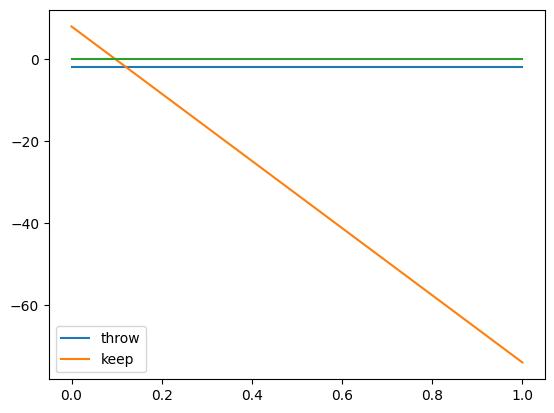

-365384 -365384 -365384


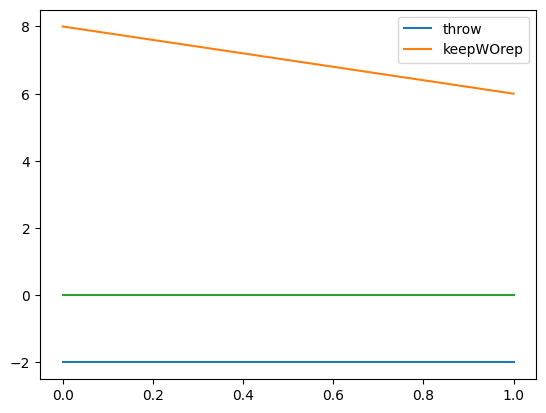

60000 60000 60000


In [73]:
def throw(p):
    return -2 * p - 2 * (1 - p)

def keep(p):
    return -74 * p + 8 * (1 - p)

def keepWOrep(p):
    return 6 * p + 8 * (1 - p)

def zero(p):
    return 0

# with rep
plot_dependencies([throw, keep, zero], ["throw", "keep"])
print(model_quality(probabilities1, data['label'], 5/41, -2, 8, -2, -74), \
      model_quality(probabilities2, data['label'], 5/41, -2, 8, -2, -74), \
      model_quality(probabilities3, data['label'], 5/41, -2, 8, -2, -74))

# without rep 
plot_dependencies([throw, keepWOrep, zero], ["throw", "keepWOrep"])
print(model_quality(probabilities1, data['label'], 5, -2, 8, -2, 6), \
      model_quality(probabilities2, data['label'], 5, -2, 8, -2, 6), \
      model_quality(probabilities3, data['label'], 5, -2, 8, -2, 6))